In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import operator
from bisect import bisect
%matplotlib inline

In [5]:
class TSP(object):
    def __init__(self,start=1,dissipation=.2,tolerance=.2,alpha=1.0,beta=1.0):
        #inputs
        self.dissipation=dissipation
        self.tolerance=tolerance
        self.alpha=alpha
        self.beta=beta
        self.start=start
        self.step=0
        
        #setup
        self.history_d={} #holds decisions about node order
        self.history_k={}
        self.history_s={}
        self.tsp=self.init_tsp()
        
        self.d=[self.start]
        self.history_d[self.step]=list(self.d)
        self.state=self.init_graph(self.tsp)
        self.history_s[self.step]=self.state.copy()
        self.k,self.last_visited=self.init_k(self.state)
        self.last_solution={}
        
        
    
    def init_tsp(self):
        #tsp=nx.Graph()
        tsp=nx.DiGraph()
        tsp.add_edge(1,2,dist=1)
        tsp.add_edge(2,1,dist=1)
        tsp.add_edge(1,3,dist=1)
        tsp.add_edge(3,1,dist=1)        
        tsp.add_edge(1,4,dist=2)
        tsp.add_edge(4,1,dist=2)
        tsp.add_edge(2,3,dist=3)
        tsp.add_edge(3,2,dist=3)
        tsp.add_edge(2,4,dist=4)
        tsp.add_edge(4,2,dist=4)
        tsp.add_edge(3,4,dist=2)
        tsp.add_edge(4,3,dist=2)
        
        return tsp
        
    def init_graph(self,tsp):
        g=tsp.copy()
        for u,v in g.edges():
            g[u][v]['p']=0.5
            g[u][v]['dist']=0.0

        #print g.edges(data=True)

        return g

    def init_k(self,g):
        k=nx.DiGraph()
        last_visited={}
        
        for u,v,d in g.edges(data=True):
            last_visited[(u,v)]={}
            n_label=k.number_of_nodes()+1
            k.add_node(n_label,label=(u,v),p=float(d['p']),step=self.step)
            last_visited[(u,v)]['p']=n_label
            n_label=k.number_of_nodes()+1
            k.add_node(n_label,label=(u,v),dist=float(d['dist']),step=self.step)
            last_visited[(u,v)]['dist']=n_label
            
        self.history_k[self.step]=k.copy()
        self.step+=1

        return k,last_visited
    
    def walk(self):
        #initialize
        g=self.state.copy()
        tsp=self.tsp.copy()
        tabu=[int(self.start)]

        for i in xrange(g.number_of_nodes()-1):
            #get pheromone list
            n_l=[]
            p_l=[]
            h_l=[]
            for n in g.nodes():
                if n not in tabu:
                    n_l.append(n)
                    p_l.append(g[tabu[-1]][n]['p'])
                    if g[tabu[-1]][n]['dist']==0.0:
                        h_l.append(10.0)
                    else:
                        h_l.append(1.0/g[tabu[-1]][n]['dist'])
                    
            c_l=np.power(p_l,self.alpha)*np.power(h_l,self.beta)
            n_index=self.make_decision(c_l)
            new_n=n_l[n_index]
                
            #update k with edge from tau and dist to edge selection
            n_label=self.k.number_of_nodes()+1
            #label is edge number in solution, e is edge added
            self.k.add_node(n_label,label=i,e=(tabu[-1],new_n),step=self.step)
            self.last_solution[i]=n_label
            for n in g.nodes():
                #if n not in tabu: #only non tabu
                if n != tabu[-1]: #no self-edge
                    e=(tabu[-1],n)
                    if (e[0],e[1]) not in self.last_visited.keys():
                        e=(e[1],e[0])

                    self.k.add_edge(self.last_visited[e]['p'],n_label,step=self.step, t=2)
                    self.k.add_edge(self.last_visited[e]['dist'],n_label,step=self.step, t=2)
                    
            for e_i in xrange(len(tabu)-1): #iterate through added edges
                #add constraining 
                last=self.last_solution[e_i]
                self.k.add_edge(last,n_label,step=self.step,t=1)
            
            #append new node
            tabu.append(new_n)

        score=0.0
        e_r=[tuple(tabu[i:i+2]) for i in xrange(0,len(tabu), 1)]
        del e_r[-1]

        for e in e_r:
            score+=float(tsp[e[0]][e[1]]['dist'])

        return tuple(tabu), score

    def update_edges(self,route,score):
        g_t=self.state.copy()
        g=self.state.copy()
        p=float(self.dissipation)
        tsp=self.tsp.copy()
        
        #print 'before', g_t.edges(data=True)
        #print 'reduction', p
        
        #update k with rout
        #n_label=self.k.number_of_nodes()+1
        #self.k.add_node(n_label,label=route,step=self.step)
        #self.last_solution['route']=n_label
        
        # k edges from tsp edge info to route - now handled in walk
        #for e in self.last_visited:
            #self.k.add_edge(self.last_visited[e]['p'],n_label,step=self.step)
            #self.k.add_edge(self.last_visited[e]['dist'],n_label,step=self.step)
            
        
        e_r=[tuple(route[i:i+2]) for i in xrange(0,len(route), 1)]
        del e_r[-1]
        t_update=1.0/score
        for u,v,d in g_t.edges(data=True):
            #update pheromone
            g_t[u][v]['p']=float(g[u][v]['p'])*(1.0-p)
            
            #update k for pheromone reduction
            last_n=self.last_visited[(u,v)]['p']
            n_label=self.k.number_of_nodes()+1
            self.k.add_node(n_label,label=(u,v),p=float(d['p']),step=self.step)
            self.k.add_edge(last_n,n_label,step=self.step,t=2)
            self.last_visited[(u,v)]['p']=n_label
        
        #add k for score
        n_label=self.k.number_of_nodes()+1
        self.k.add_node(n_label,score=score,step=self.step)
        
        #add k from route selections to score
        for sel,n in self.last_solution.iteritems():
            if sel != 'score':
                self.k.add_edge(n,n_label,step=self.step,t=1)
        
        self.last_solution['score']=n_label
        
        for e in e_r:
            sel_index=e_r.index(e)
            #check ordering
            if (e[0],e[1]) not in self.last_visited.keys():
                e=(e[1],e[0])
            
            #update dist
            if g_t[e[0]][e[1]]['dist']==0.0:
                dist=float(tsp[e[0]][e[1]]['dist'])
                g_t[e[0]][e[1]]['dist']=dist
                
                #update k for changed distance
                n_label=self.k.number_of_nodes()+1
                last_n=self.last_visited[(e[0],e[1])]['dist']
                self.k.add_node(n_label,label=(e[0],e[1]),dist=float(dist),step=self.step)
                self.k.add_edge(last_n,n_label,step=self.step,t=2)
                self.k.add_edge(self.last_solution[sel_index],n_label,step=self.step,t=1)
                
                self.last_visited[(e[0],e[1])]['dist']=n_label
                
                #update k for route score
                #self.k.add_edge(n_label,self.last_solution['score'],step=self.step)

            #update k for route score
            last_n=self.last_visited[(e[0],e[1])]['dist']
            self.k.add_edge(last_n,self.last_solution['score'],step=self.step,t=1)
                
                
            #update pheromones on included edges    
            g_t[e[0]][e[1]]['p']=float(g_t[e[0]][e[1]]['p'])+t_update*p
            
            #update k for pheromone addition - add edge for walk update
            last_n=self.last_visited[(e[0],e[1])]['p']
            self.k.node[last_n]['p']=float(g_t[e[0]][e[1]]['p'])
            #n_label=self.k.number_of_nodes()+1
            #self.k.add_node(n_label,label=(e[0],e[1]),p=float(g_t[e[0]][e[1]]['p']),step=self.step)
            #self.k.add_edge(last_n,n_label,step=self.step)
            self.k.add_edge(self.last_solution[sel_index],last_n,step=self.step,t=2)
            self.k.add_edge(self.last_solution['score'],last_n,step=self.step,t=2)
            #self.last_visited[(e[0],e[1])]['p']=n_label
        
        g_t=self.design(g_t,tolerance=self.tolerance)
        
        self.history_d[self.step]=list(self.d)
        self.history_k[self.step]=self.k.copy()
        self.history_s[self.step]=g_t.copy()
        self.step+=1
        #print 'after', g_t.edges(data=True)    
        return g_t

    def design(self,g,tolerance):
        #makes locks-in step in walk if p(1st node)-p(2nd node)
        #g=self.state.copy()
        g_t=g.copy()
        
        while True:
            if len(self.d)==(g.number_of_nodes()):
                break
            dec_node=self.d[-1]
        
            #Get probabilities
            #get pheromone list
            n_l=[]
            p_l=[]
            h_l=[]
            for n in g.nodes():
                if n not in self.d:
                    n_l.append(n)
                    p_l.append(g[self.d[-1]][n]['p'])
                    
                    if g[self.d[-1]][n]['dist']==0.0: #only look at edges nodes
                        h_l.append(0.0)
                    else:
                        h_l.append(1.0/g[self.d[-1]][n]['dist'])
                    
            ph_l=np.power(p_l,self.alpha)*np.power(h_l,0.0) #only use pheromone preference
            if sum(ph_l)==0.0:
                perc_l=[1.0/len(ph_l)]*len(ph_l)
            else:
                perc_l=[float(i)/sum(ph_l) for i in ph_l]
            l=list(perc_l)
            #print perc_l
            m_1=l.pop(l.index(max(l)))
            #print l,m_1
            #print m_1-max(l)
            
            if not l: #only one option
                #print 'decision'
                dec_index=perc_l.index(max(perc_l)) #decision index
                node=n_l[dec_index]
                self.d.append(node) #add node to decisions
            
                #Eliminate other edge options
                for n in g.nodes():
                    if n not in self.d:
                        g_t[dec_node][n]['p']=0.0 #now prob of taking that edges is 0
            
            elif (m_1-max(l))>=tolerance: #prob gap is larger than tolerance 
                #print 'decision'
                dec_index=perc_l.index(max(perc_l)) #decision index
                node=n_l[dec_index]
                self.d.append(node) #add node to decisions
            
                #Eliminate other edge options
                for n in g.nodes():
                    if n not in self.d:
                        g_t[dec_node][n]['p']=0.0 #now prob of taking that edges is 0
                        
                #break
            else:
                break
                
        #self.history_d[self.step]=self.d
            
        return g_t
                
            
        

    def make_decision(self,ph_l):
        """
        Return decision index, based on pheromone list.
        """
        #convert pheromones to percentage
        if sum(ph_l)==0.0:
            percent_list=[1.0/len(ph_l)]*len(ph_l)
        else:
            percent_list = [float(i)/sum(ph_l) for i in ph_l]   
        cumulative_percent=np.cumsum(percent_list)
        #print cumulative_percent

        #Choose decision index
        select_index=bisect(cumulative_percent,np.random.uniform(0,1,1))

        return select_index




    def k_step(k,t_new,t_old,route,last_visited,changed_d):
        #get step number

        #route
        n_label=k.number_of_nodes()+1
        k.add_node(n_label,r=tuple(route),step=step)

        #changed distance
        for e in changed_d:
            n_label=k.number_of_nodes()+1
            k.add_node(n_label,)

        for e,d in last_visited.iteritems():
            print 'hi'




[(1, 2, {'p': 0.24064879138065243, 'dist': 1.0}), (1, 3, {'p': 0.0019760152251757706, 'dist': 1.0}), (1, 4, {'p': 0.0015111572745182887, 'dist': 0.0}), (2, 1, {'p': 0.00217278049529534, 'dist': 1.0}), (2, 3, {'p': 0.019739862125400687, 'dist': 3.0}), (2, 4, {'p': 0.0015111572745182887, 'dist': 0.0}), (3, 1, {'p': 0.22242008652977002, 'dist': 1.0}), (3, 2, {'p': 0.0, 'dist': 3.0}), (3, 4, {'p': 0.0015111572745182887, 'dist': 0.0}), (4, 1, {'p': 0.0, 'dist': 2.0}), (4, 2, {'p': 0.0, 'dist': 4.0}), (4, 3, {'p': 0.2226168517998896, 'dist': 2.0})]
[4, 3, 1, 2]


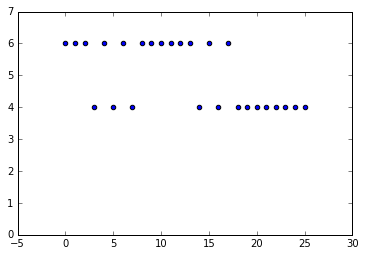

In [6]:
t=TSP(start=4,tolerance=0.8)

routes=[]
for i in xrange(100):
    r,s=t.walk()
    routes.append((r,s))
    t.state=t.update_edges(r,s)
    if len(t.d)==t.state.number_of_nodes():
        break
    #print t.edges(data=True)
                  
#print routes
print t.state.edges(data=True)
print t.d

s=[i[1] for i in routes]
gen=xrange(len(s))
plt.scatter(gen,s)
_=plt.ylim([0.0,max(s)+1.0])

In [7]:
for n, d in t.k.nodes(data=True):
    print n,d

1 {'p': 0.5, 'step': 0, 'label': (1, 2)}
2 {'step': 0, 'dist': 0.0, 'label': (1, 2)}
3 {'p': 0.5, 'step': 0, 'label': (1, 3)}
4 {'step': 0, 'dist': 0.0, 'label': (1, 3)}
5 {'p': 0.5, 'step': 0, 'label': (1, 4)}
6 {'step': 0, 'dist': 0.0, 'label': (1, 4)}
7 {'p': 0.5, 'step': 0, 'label': (2, 1)}
8 {'step': 0, 'dist': 0.0, 'label': (2, 1)}
9 {'p': 0.5, 'step': 0, 'label': (2, 3)}
10 {'step': 0, 'dist': 0.0, 'label': (2, 3)}
11 {'p': 0.5, 'step': 0, 'label': (2, 4)}
12 {'step': 0, 'dist': 0.0, 'label': (2, 4)}
13 {'p': 0.5, 'step': 0, 'label': (3, 1)}
14 {'step': 0, 'dist': 0.0, 'label': (3, 1)}
15 {'p': 0.5, 'step': 0, 'label': (3, 2)}
16 {'step': 0, 'dist': 0.0, 'label': (3, 2)}
17 {'p': 0.5, 'step': 0, 'label': (3, 4)}
18 {'step': 0, 'dist': 0.0, 'label': (3, 4)}
19 {'p': 0.5, 'step': 0, 'label': (4, 1)}
20 {'step': 0, 'dist': 0.0, 'label': (4, 1)}
21 {'p': 0.5, 'step': 0, 'label': (4, 2)}
22 {'step': 0, 'dist': 0.0, 'label': (4, 2)}
23 {'p': 0.5, 'step': 0, 'label': (4, 3)}
24 {'step'

In [103]:
for i in xrange(len(routes)):
    print i,t.history_d[i],routes[i][0],routes[i][1]

0 [4] (4, 3, 2, 1) 6.0
1 [4] (4, 1, 2, 3) 6.0
2 [4] (4, 2, 1, 3) 6.0
3 [4] (4, 1, 3, 2) 6.0
4 [4] (4, 2, 3, 1) 8.0
5 [4] (4, 2, 1, 3) 6.0
6 [4] (4, 2, 3, 1) 8.0
7 [4] (4, 2, 1, 3) 6.0
8 [4] (4, 3, 1, 2) 4.0
9 [4] (4, 3, 1, 2) 4.0
10 [4] (4, 3, 1, 2) 4.0
11 [4] (4, 3, 1, 2) 4.0
12 [4] (4, 3, 1, 2) 4.0
13 [4] (4, 3, 1, 2) 4.0
14 [4] (4, 3, 1, 2) 4.0
15 [4] (4, 3, 1, 2) 4.0
16 [4] (4, 2, 1, 3) 6.0
17 [4] (4, 3, 1, 2) 4.0
18 [4] (4, 3, 1, 2) 4.0
19 [4] (4, 3, 1, 2) 4.0
20 [4] (4, 3, 1, 2) 4.0
21 [4] (4, 3, 1, 2) 4.0
22 [4] (4, 3, 1, 2) 4.0
23 [4] (4, 2, 1, 3) 6.0
24 [4] (4, 3, 1, 2) 4.0
25 [4] (4, 3, 1, 2) 4.0
26 [4] (4, 1, 3, 2) 6.0
27 [4] (4, 3, 1, 2) 4.0
28 [4] (4, 1, 3, 2) 6.0
29 [4] (4, 1, 3, 2) 6.0
30 [4] (4, 1, 3, 2) 6.0
31 [4] (4, 3, 2, 1) 6.0
32 [4] (4, 3, 1, 2) 4.0
33 [4] (4, 3, 1, 2) 4.0
34 [4] (4, 3, 1, 2) 4.0
35 [4] (4, 3, 1, 2) 4.0
36 [4] (4, 3, 1, 2) 4.0
37 [4] (4, 3, 1, 2) 4.0
38 [4] (4, 3, 1, 2) 4.0
39 [4] (4, 3, 1, 2) 4.0
40 [4] (4, 1, 2, 3) 6.0
41 [4] (4, 3, 1, 2) 4.0
42

In [104]:
bc=nx.betweenness_centrality(t.k)
m_key=max(bc.iteritems(), key=operator.itemgetter(1))[0]
print m_key
print bc[m_key]
print t.k.node[m_key]

#for u,v,d in t.k.edges(data=True):
    #print (u,v),d

597
0.0474473708498
{'p': 0.24844629167321636, 'step': 58, 'label': (3, 4)}


In [106]:
kc=nx.katz_centrality(t.k)
m_key=max(kc.iteritems(), key=operator.itemgetter(1))[0]
print m_key

print kc[m_key]
print t.k.node[m_key]

531
0.0422591450023
{'step': 52, 'e': (1, 2), 'label': 2}


In [38]:
l=[.1,.2,.7]
m_1=l.pop(l.index(max(l)))
print m_1
print l

0.7
[0.1, 0.2]


In [39]:
max([])

ValueError: max() arg is an empty sequence